In [1]:
import kagglehub
# Logistic regression almost identical to linear regression model with weights and bias matrices, pred = x @ w.t() + b
## Since image is (rgb,x,y), (1,28,28), nn.Linear expects a vector of 28x28, size 784...
## Output is vect;or of size 10, with each element signifying probbabiliy a particular target label (0 - 9). Predicted label is one with highest probability
#https://www.kaggle.com/datasets/hojjatk/mnist-dataset
# Download latest version
# path = kagglehub.dataset_download("hojjatk/mnist-dataset")
# print("Path to dataset files:", path)

In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

dataset = MNIST(root='data/', download=True)#, transform=transforms.ToTensor())
len(dataset)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 51.3MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.18MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.29MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



60000

Label: 5


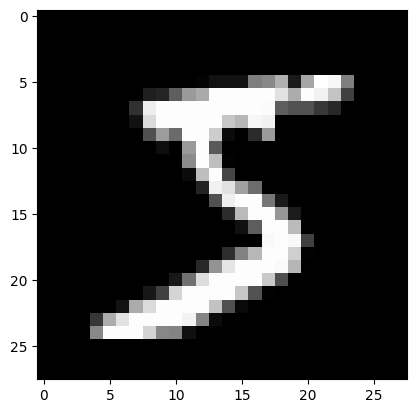

In [3]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

image, label = dataset[0]
plt.imshow(image, cmap='gray')
# plt.imshow(img.squeeze(), cmap='gray')
print('Label:', label)


Label: 3


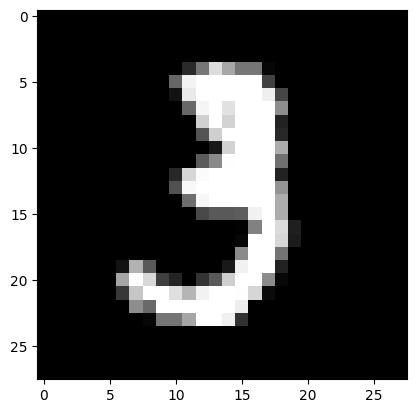

In [4]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
# plt.imshow(img.squeeze(), cmap='gray')
print('Label:', label)

In [5]:

# transform converts images into tensors
dataset = MNIST(root='data/', download=True, transform=transforms.ToTensor())
img_tensor, label = dataset[0]
print(img_tensor.shape, 'Label:',label)

torch.Size([1, 28, 28]) Label: 5


1. Training Set:_______compute loss & adjust weights of model using gradient descent
2. Validation Set:_____adjust hyperparameters, i.e. learning rate, and pick best version
3. Test Set: __________compare models

In [6]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor))
print(torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.)
tensor(0.)


In [7]:
def split_indices(n, val_pct):
    n_val = int(n*val_pct) # size of validation set, n=60000 & val_pct=0.1
    idxs = np.random.permutation(n) # create random permutation of 0 to n-1
    return idxs[n_val:], idxs[:n_val] # pick first n_val indices for validation set

split_indices randomly shuffles the array indices and separates out a specified portion (training images are often ordered by target lables, i.e. images of 0s, followed b images of 1's, followed by 2's

In [8]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)
print(len(train_indices), len(val_indices))
print('Sample train indices', train_indices[:10])
print('Sample val indices', val_indices[:10])

48000 12000
Sample train indices [ 4669 26095 36769 47716 51730 26913 52265 51767 31462 38186]
Sample val indices [43013 48785 36288 57762 25027 51619 41767 50360  9399 37767]


In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size = 100
#training
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, sampler=train_sampler)
#validation
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

In [10]:
import torch.nn as nn
input_size = 28 * 28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-3.2323e-02, -2.0849e-02, -2.5424e-03,  ..., -2.6597e-02,
         -3.2966e-02, -1.2410e-02],
        [ 3.0515e-02,  4.4917e-03,  7.8155e-03,  ...,  8.3983e-05,
          1.0025e-02,  1.7679e-02],
        [-1.2185e-02,  2.7819e-02,  1.6537e-02,  ..., -3.5408e-02,
          5.1771e-03,  1.3270e-02],
        ...,
        [ 2.9207e-02, -1.3808e-02, -1.3694e-03,  ..., -1.1295e-02,
         -2.5508e-02, -6.7735e-03],
        [ 1.9905e-02, -1.6001e-02,  1.7940e-02,  ...,  1.6014e-02,
         -9.9847e-03, -1.2029e-02],
        [ 4.9074e-04, -1.4707e-03, -3.1043e-02,  ...,  9.2425e-03,
          3.2683e-02, -1.4271e-02]], requires_grad=True)

In [11]:
print (model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0047,  0.0183, -0.0155,  0.0076, -0.0292,  0.0305, -0.0063,  0.0088,
        -0.0221,  0.0336], requires_grad=True)

In [12]:
# for images, labels in train_loader:
#     print(labels)
#     print(images.shape)
#     # images = images.reshape(-1, 28*28)
#     # print('reshape images.shape:', images.shape)
#     outputs = model(images)
#     break
    ## Without reshape, outputs error due to torch.Size([100,1,28,28])
    ## Must flatten 1,28,28

In [13]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = MnistModel()

*Inside __init__ constructor method, is instantiated the weights and biases using nn.Linear,
*Inside forward(a,b) method which is invoked when passing a batch of ## inputs to model, it flattens out the input tensor, then passing to self.linear(xb)
*-1 allows to work with any batch size

In [14]:
print(model.linear.weight.shape, model.linear.bias.shape) # .weight and .bias are now inside linear
list(model.parameters())


torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0293, -0.0136, -0.0205,  ..., -0.0041,  0.0228, -0.0240],
         [-0.0012, -0.0267, -0.0344,  ...,  0.0138, -0.0323,  0.0247],
         [ 0.0192,  0.0116, -0.0074,  ...,  0.0147, -0.0263,  0.0349],
         ...,
         [-0.0005,  0.0070,  0.0234,  ..., -0.0121, -0.0212,  0.0154],
         [ 0.0209,  0.0172, -0.0130,  ..., -0.0343, -0.0241, -0.0137],
         [ 0.0054,  0.0094,  0.0117,  ...,  0.0089,  0.0050, -0.0139]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0267,  0.0180,  0.0208,  0.0247, -0.0147,  0.0191,  0.0122, -0.0020,
         -0.0046, -0.0192], requires_grad=True)]

In [15]:
for images, labels in train_loader:
    # print(labels)
    # print(images.shape)
    outputs = model(images)
    break
print('outputs.shape : ', outputs.shape) # should be [100, 10]
print('Sample outputs:\n', outputs[:2].data)
# outputs a few negatives, which shouldn't be... so use SoftMax!!
# SoftMax
# makes positive, and also makes larger, pushing model to one particular output, hence Logit! not probabiility
# replaces

outputs.shape :  torch.Size([100, 10])
Sample outputs:
 tensor([[ 0.1782,  0.2349,  0.2093,  0.2971, -0.1038,  0.1728, -0.1909,  0.0708,
          0.1057, -0.1461],
        [-0.2881, -0.4742, -0.4007, -0.2914,  0.0148,  0.6015, -0.2224,  0.3642,
         -0.0813, -0.2296]])


In [16]:
import torch.nn.functional as F

probs = F.softmax(outputs, dim=1)
print('Sample probabilities:\n', probs[:2].data)
print('Sum: ', torch.sum(probs[0]).item()) # add up probabilities of an outpu row.

Sample probabilities:
 tensor([[0.1086, 0.1149, 0.1120, 0.1223, 0.0819, 0.1080, 0.0751, 0.0975, 0.1010,
         0.0785],
        [0.0782, 0.0649, 0.0699, 0.0780, 0.1059, 0.1904, 0.0835, 0.1502, 0.0962,
         0.0829]])
Sum:  1.0


In [17]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([3, 5, 5, 5, 8, 7, 3, 0, 5, 5, 2, 5, 5, 5, 7, 5, 2, 5, 5, 5, 5, 6, 2, 3,
        3, 5, 5, 5, 5, 8, 5, 5, 5, 2, 7, 5, 5, 5, 5, 8, 6, 2, 5, 8, 5, 5, 5, 5,
        5, 5, 5, 3, 5, 5, 5, 5, 3, 5, 0, 7, 7, 2, 3, 3, 5, 5, 7, 6, 5, 5, 2, 8,
        8, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 3, 5, 3, 5, 1, 5, 0, 5, 5, 5, 5, 8,
        7, 2, 7, 5])
tensor([0.1223, 0.1904, 0.1405, 0.1404, 0.1367, 0.1312, 0.1187, 0.1209, 0.2011,
        0.1249, 0.1316, 0.1171, 0.1305, 0.1624, 0.1286, 0.1659, 0.1195, 0.1518,
        0.1370, 0.1395, 0.2010, 0.1180, 0.1374, 0.1241, 0.1169, 0.1439, 0.1808,
        0.1245, 0.1180, 0.1168, 0.1278, 0.1276, 0.1255, 0.1355, 0.1418, 0.1499,
        0.1145, 0.1383, 0.1411, 0.1129, 0.1234, 0.1295, 0.1344, 0.1284, 0.1486,
        0.1702, 0.1281, 0.1563, 0.1420, 0.1453, 0.1341, 0.1538, 0.1316, 0.1750,
        0.1645, 0.1442, 0.1262, 0.1735, 0.1247, 0.1263, 0.1699, 0.1294, 0.1370,
        0.1257, 0.1532, 0.1729, 0.1422, 0.1161, 0.1808, 0.1356, 0.1225, 0.1410,
        0.1241, 0.1

In [18]:
torch.sum(labels == preds) / len (labels)
 # compare real digits with expected digits
# numbers are off since weights were chosen randomly

tensor(0.0900)

In [19]:
def accuracy1(labels_1,preds_2):
  return torch.sum(labels_1 == preds_2).item() / len(labels_1)
accuracy1(preds, labels)


0.09

Problems with accuracy is not differentiable function:
1. torch.max & == are both non-continuousand non-differentiable operations, so can't use accuracy for computing gradients w.r.t. weights and biases.
2. doen'st take into acccount actual proabilities predicted by model
So, not good loss function for classification probs, must use cross entropy, which takes the 10 outputs, and picks of the 10, the 1 correspoonding to highest probability. So take logarithm of highest.
preds close to one, lower the loss

In [20]:
loss_fn = F.cross_entropy
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2975, grad_fn=<NllLossBackward0>)


Output is: tensor(2.292)
To interpret, take e^-2.29 = .1

In [21]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
### 1. calcualtes loss for batch of data,
### 2. optionally performs gradient descent update step if optimizer provided,
### 3. optionally coputes a metric of accuracy using preds and targets
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    if opt is not None:
        loss.backward() # compute gradients
        opt.step() # update parameters
        opt.zero_grad() # reset gradients
    metric_result = None
    if metric is not None: #compute metric
      metric_result = metric(preds,yb)

    return loss.item(), len(xb), metric_result

In [23]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad(): # pass each batch through model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results) # separate losses, counts and metrics
        total = np.sum(nums) #total size of dataset
        avg_loss = np.sum(np.multiply(losses, nums)) / total # average loss
        avg_metric = None
        if metric is not None:  # avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric
#

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)
#

* Softmax not needed for outputs since it doesn't change the relative order of the results.
*because e^x is an increasing function (y1>y2,then e^y1>e^y2)

In [25]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader,metric=accuracy)

print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))
# loss: 2.3

Loss: 2.2844, Accuracy: 0.0839


In [26]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        #Training
        for xb, yb in train_dl:
           loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt) # takes data batch by batch by batch performingin gradient descent
        #Evalution
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        #print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
          print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))
#


In [27]:
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.8885, accuracy: 0.6455
Epoch [2/5], Loss: 1.5878, accuracy: 0.7431
Epoch [3/5], Loss: 1.3765, accuracy: 0.7730
Epoch [4/5], Loss: 1.2244, accuracy: 0.7913
Epoch [5/5], Loss: 1.1117, accuracy: 0.8043


In [29]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.0253, accuracy: 0.8131
Epoch [2/5], Loss: 0.9571, accuracy: 0.8191
Epoch [3/5], Loss: 0.9021, accuracy: 0.8237
Epoch [4/5], Loss: 0.8567, accuracy: 0.8279
Epoch [5/5], Loss: 0.8186, accuracy: 0.8334


In [30]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 0.7861, accuracy: 0.8370
Epoch [2/5], Loss: 0.7580, accuracy: 0.8406
Epoch [3/5], Loss: 0.7335, accuracy: 0.8434
Epoch [4/5], Loss: 0.7119, accuracy: 0.8465
Epoch [5/5], Loss: 0.6927, accuracy: 0.8490


In [31]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 0.6754, accuracy: 0.8512
Epoch [2/5], Loss: 0.6599, accuracy: 0.8532
Epoch [3/5], Loss: 0.6458, accuracy: 0.8545
Epoch [4/5], Loss: 0.6329, accuracy: 0.8570
Epoch [5/5], Loss: 0.6211, accuracy: 0.8577


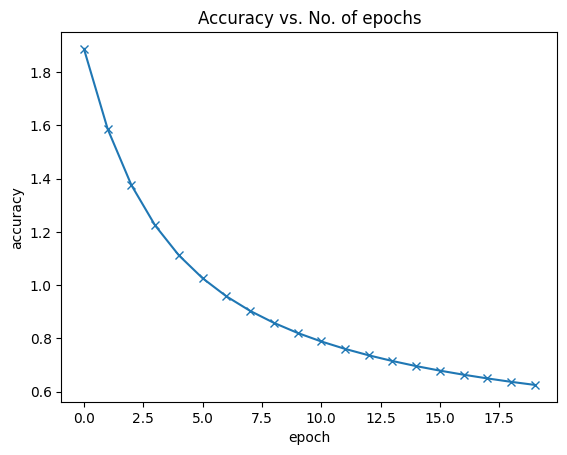

In [32]:
loss = [
1.8867,
1.5860,
1.3754,
1.2241,
1.1120,
1.0261,
0.9583,
0.9037,
0.8588,
0.8209,
0.7888,
0.7610,
0.7368,
0.7154,
0.6963,
0.6793,
0.6640,
0.6501 ,
0.6373 ,
0.6257,
]
plt.plot(loss, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losss vs. No. of epochs');

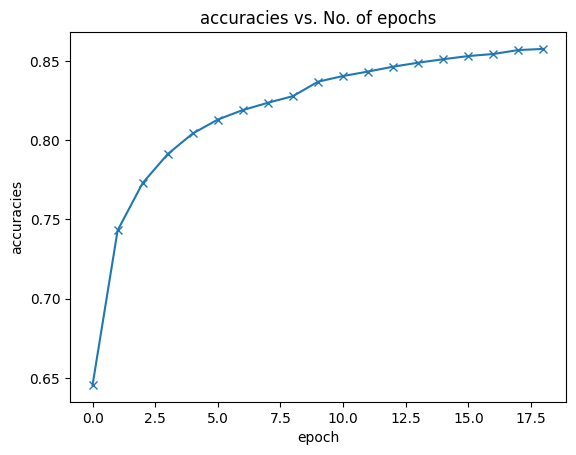

In [33]:
accuracies = [
  0.6455,
  0.7431,
  0.7730,
  0.7913,
  0.8043,
  0.8131,
 0.8191,
  0.8237,
  0.8279,
  0.8370,
  0.8406,
 0.8434,
  0.8465,
  0.8490,
  0.8512,
 0.8532,
  0.8545,
 0.8570,
 0.8577
]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('accuracies vs. No. of epochs');
# 2.55